In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
# import matplotlib
import matplotlib.pyplot as plt

import random
# import sklearn

from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

from copy import deepcopy
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.cluster import KMeans

def setup_seed(seed):
    #--- Fix random seed ---#
    np.random.seed(seed)
    random.seed(seed)
seed = 1105
setup_seed(seed)

import os
cwd = os.getcwd()
base_path = os.path.abspath(os.path.join(cwd, '../../'))

## Fig.6 Exploration of cell heterogeneity in PBMCs and cell origin in pan-cancer data

- UMAP visualization of true protein colored by cell type and batch information

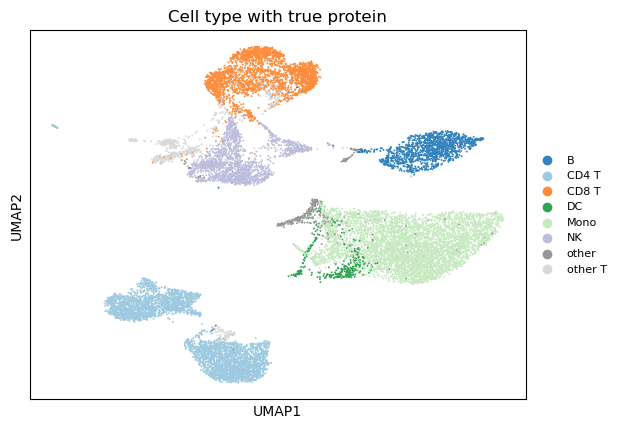

In [2]:
data_path = base_path + '/result/fig6/seuratv4_finetune_true_scP_adata.h5ad'
true_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(true_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with true protein')
plt.show()

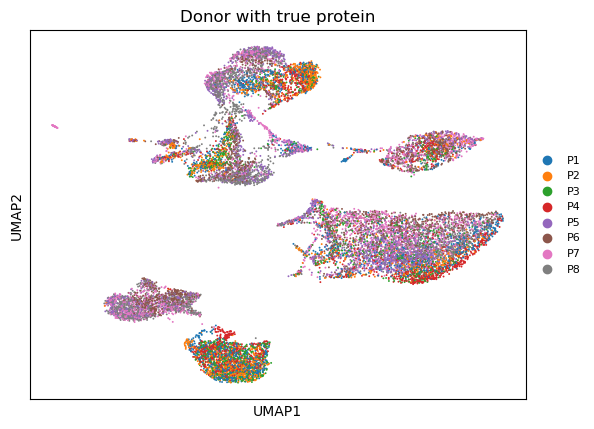

In [3]:
ax = sc.pl.umap(true_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with true protein')
plt.show()

- UMAP visualization of predicted protein colored by cell type and batch information

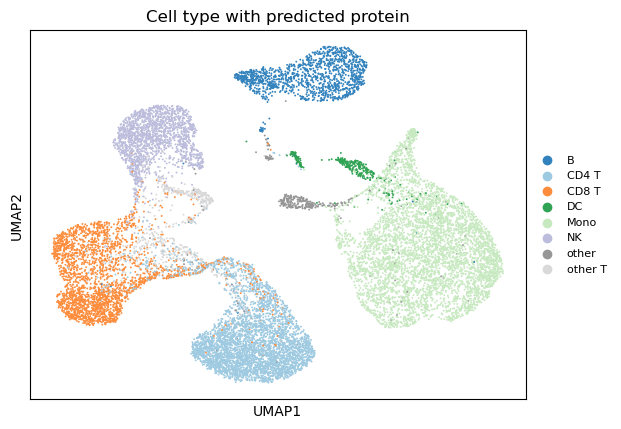

In [4]:
data_path = base_path + '/result/fig6/seuratv4_finetune_pred_scP_adata.h5ad'
pro_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(pro_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with predicted protein')
plt.show()


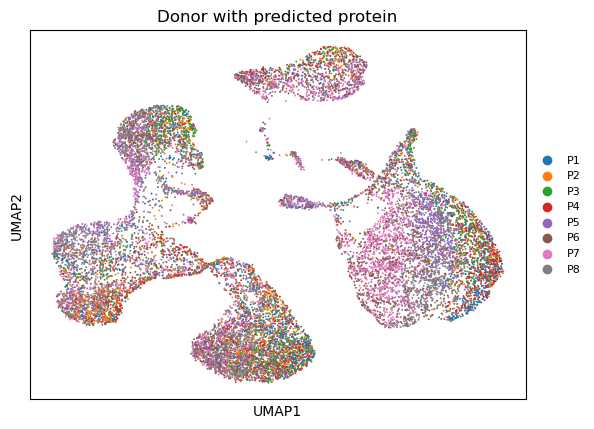

In [5]:
ax = sc.pl.umap(pro_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with predicted protein')
plt.show()

- UMAP visualization of predicted protein colored by cell type and batch information

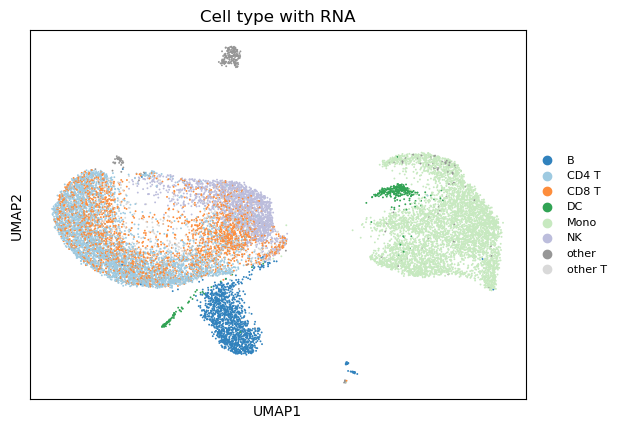

In [6]:
data_path = base_path + '/result/fig6/seuratv4_finetune_scRNA_adata.h5ad'
rna_adata = sc.read_h5ad(data_path)
ax = sc.pl.umap(rna_adata, color=['celltype.l1'], legend_fontsize=8, palette='tab20c', show=False)
ax.set_title('Cell type with RNA')
plt.show()

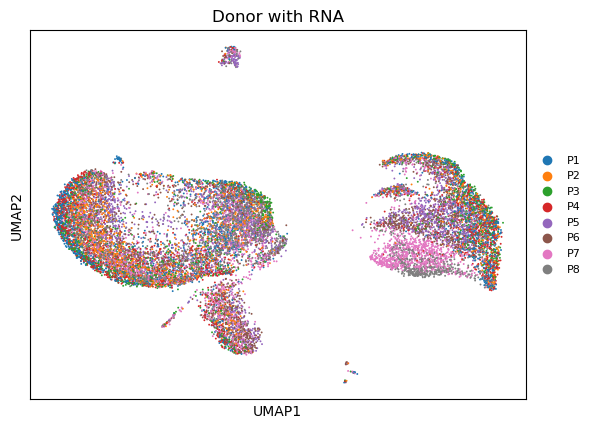

In [7]:
ax = sc.pl.umap(rna_adata, color=['donor'], legend_fontsize=8, show=False)
ax.set_title('Donor with RNA')
plt.show()

- Maker identification for different cell types

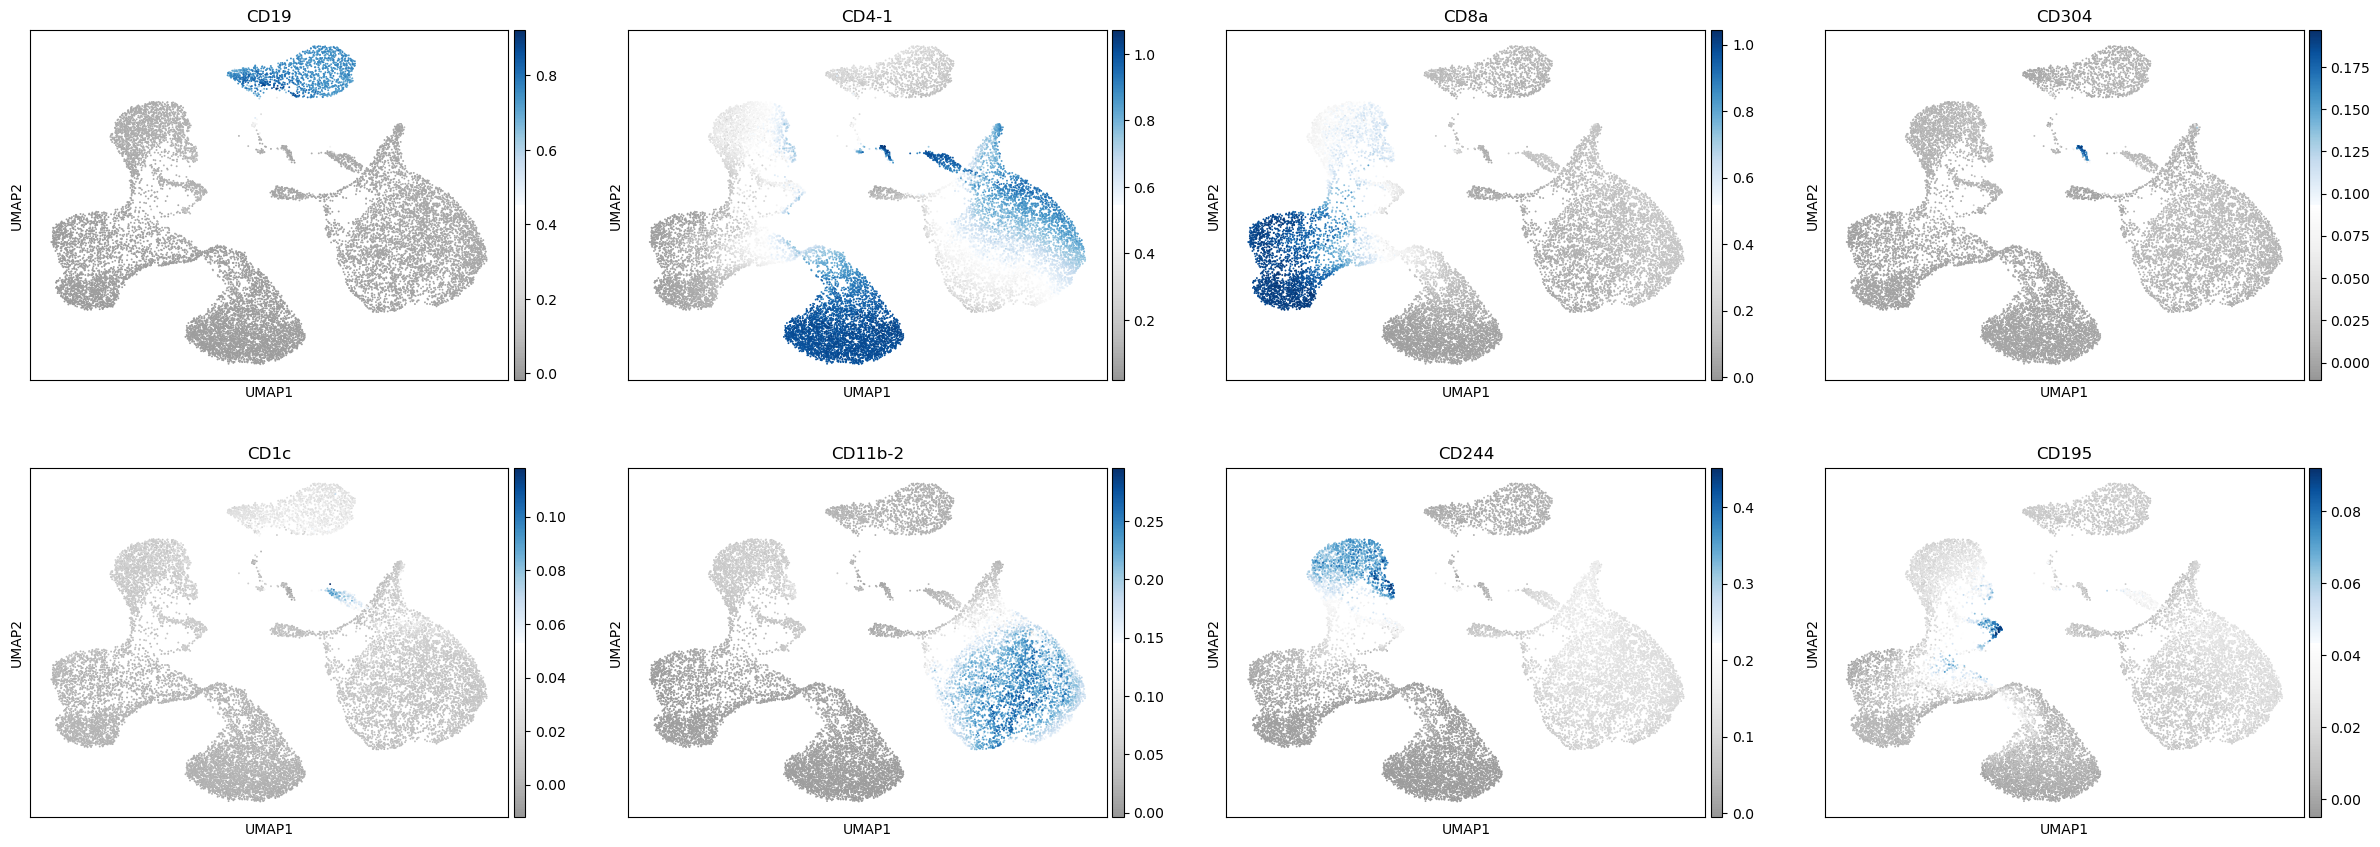

In [8]:
num_color = 128
top = cm.get_cmap('Greys_r', num_color)
bottom = cm.get_cmap('Blues', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)

gene_list = ['CD19', 'CD4-1', 'CD8a', 'CD304', 'CD1c', 'CD11b-2', 'CD244', 'CD195']
sc.pl.umap(pro_adata, color=[i for i in gene_list], color_map=newcmp, legend_fontsize=8) 

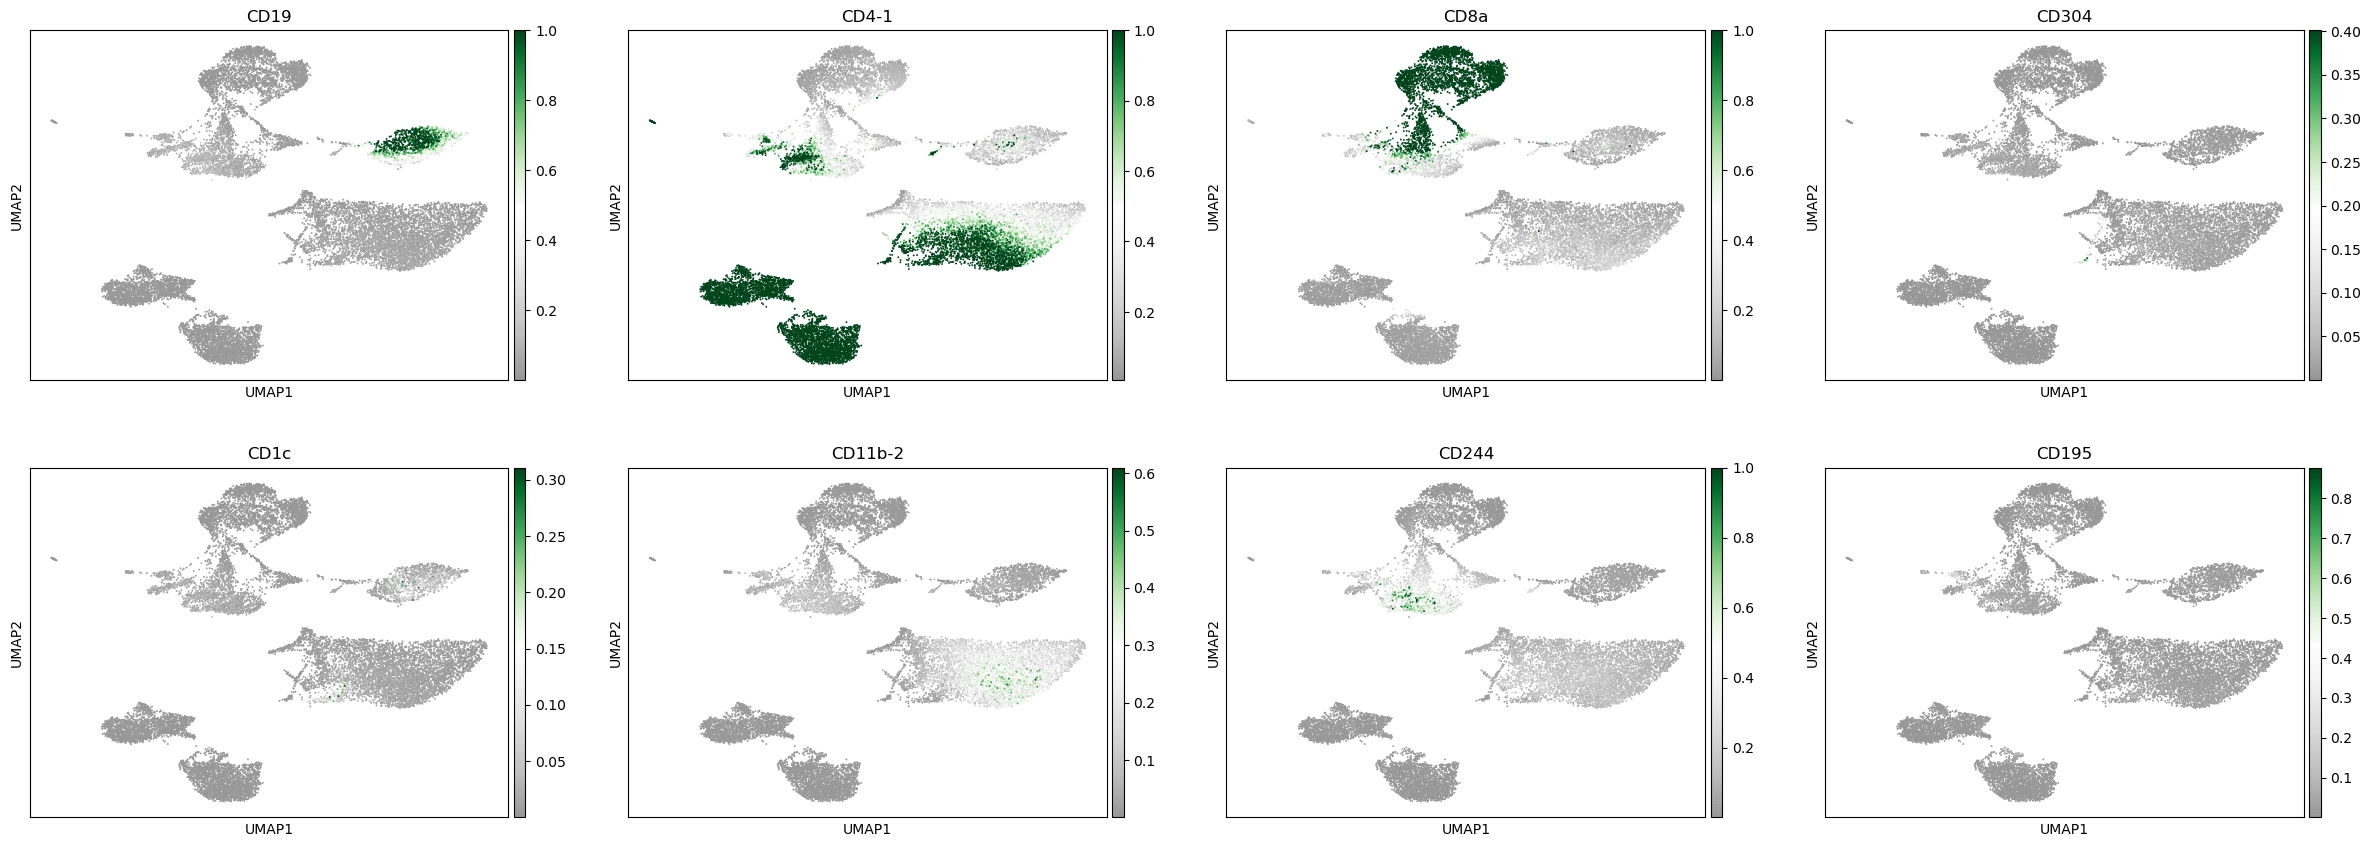

In [9]:
bottom = cm.get_cmap('Greens', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)
sc.pl.umap(true_adata, color=[i for i in gene_list], color_map=newcmp, legend_fontsize=8) 

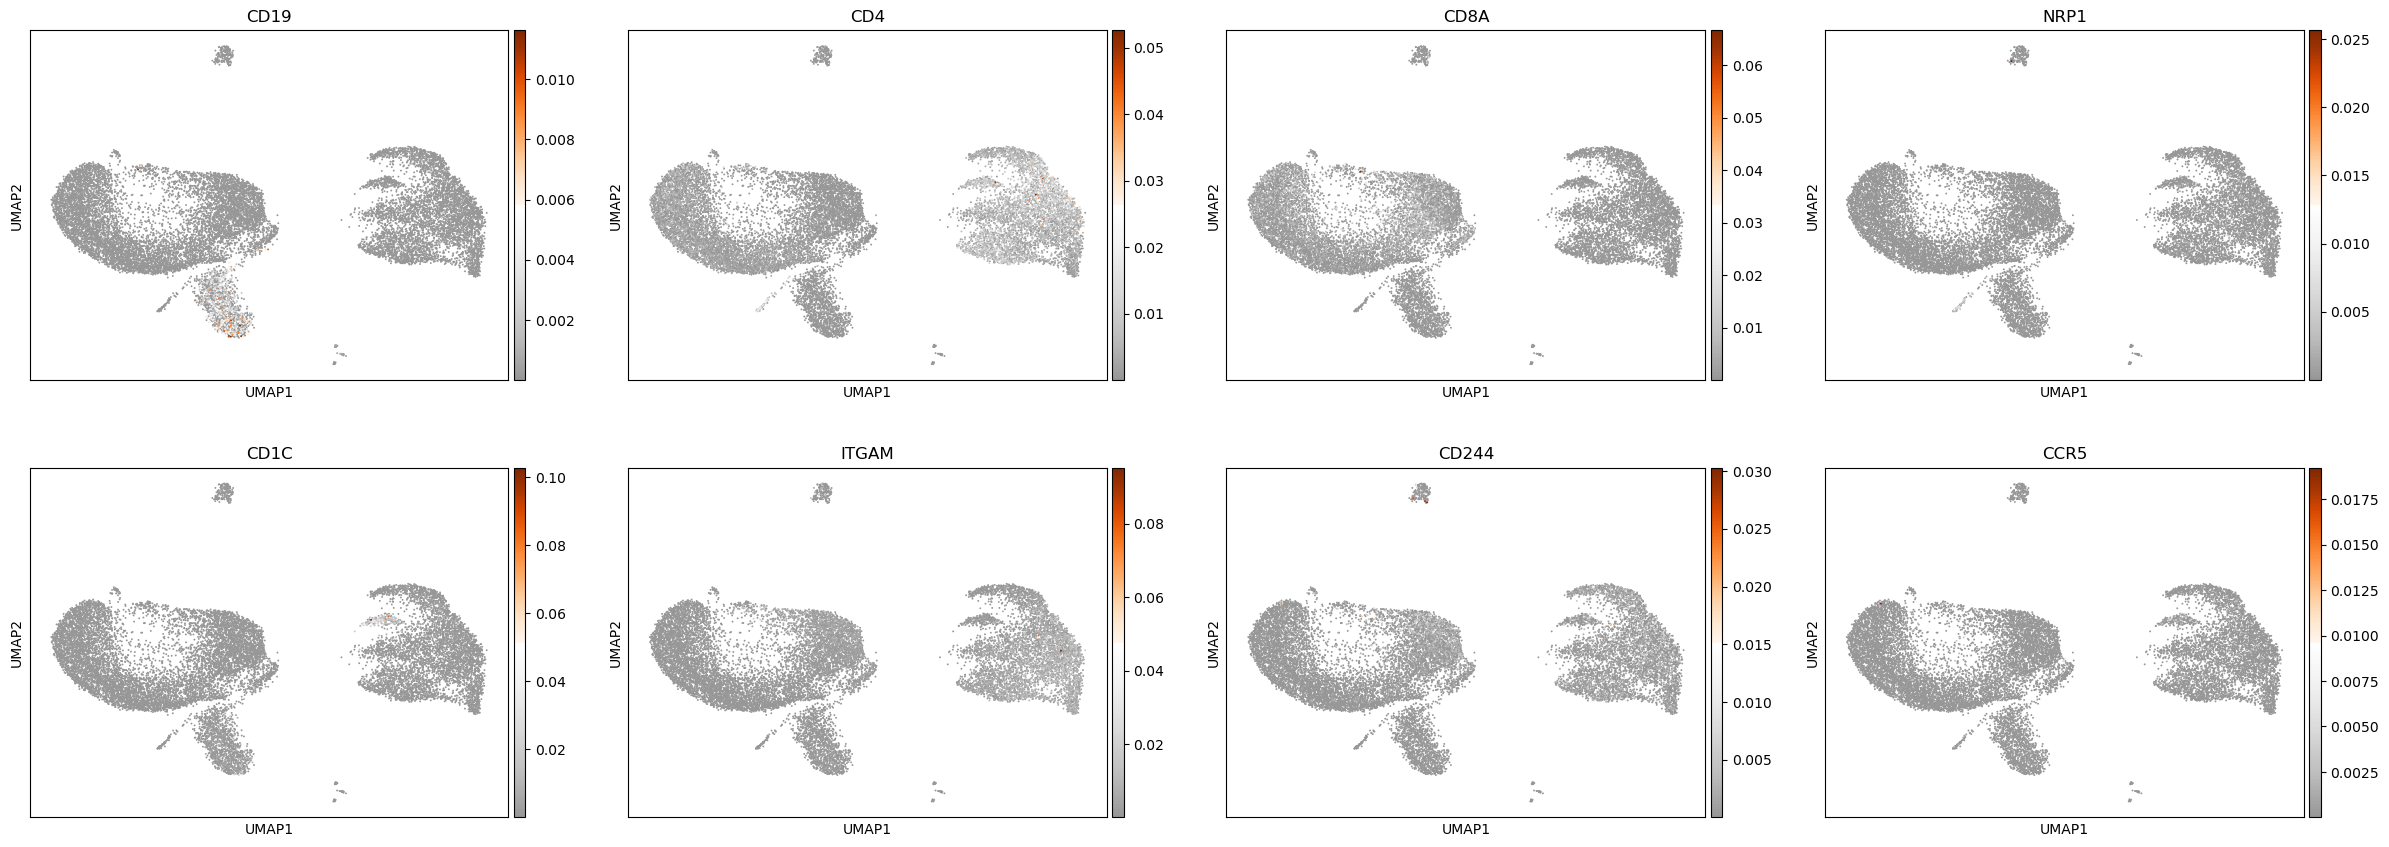

In [10]:
bottom = cm.get_cmap('Oranges', num_color)
newcolors = np.vstack((top(np.linspace(0.5, 1, num_color)),
                       bottom(np.linspace(0, 1, num_color))))
newcmp = ListedColormap(newcolors)

ID = 'Entrez_Gene_Id'
gene_list_rna = [rna_adata.var[rna_adata.var[ID].values==j].index[0] for j in pro_adata.var.loc[gene_list,ID].values if j in rna_adata.var[ID].values]
gene_list_rna.insert(5, 'ITGAM')
sc.pl.umap(rna_adata, color=[i for i in gene_list_rna], color_map=newcmp, legend_fontsize=8) 

- Performance of cell clustering

In [11]:
n_clusters = 8
level = 'l1'
label_level = 'celltype.'+level

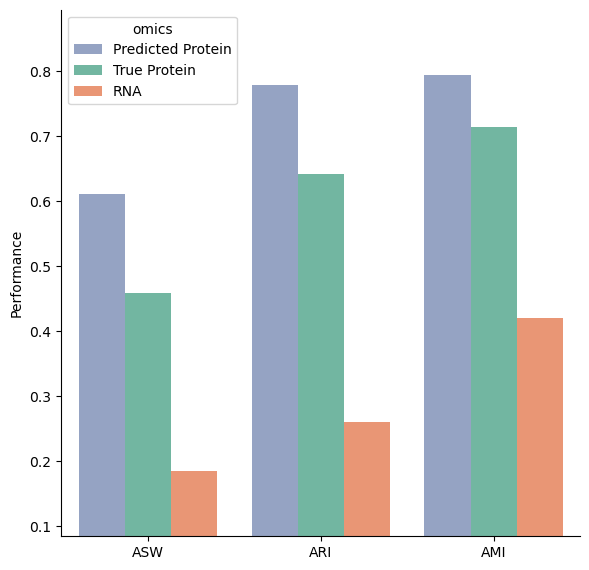

In [12]:
# True protein
adata = deepcopy(true_adata)
label_enc = preprocessing.LabelEncoder()
labels_true = label_enc.fit_transform(adata.obs[label_level].values)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4)
truth_result = ['True Protein', ARI, AMI, ASW]

# Predicted protein
adata = deepcopy(pro_adata)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4) 
pred_result = ['Predicted Protein', ARI, AMI, ASW]

# RNA
adata = deepcopy(rna_adata)
kmeans = KMeans(n_clusters=8).fit(adata.X)
adata.obs['cluster'] = kmeans.labels_
ARI = np.round(adjusted_rand_score(labels_true, adata.obs['cluster']), 4)
AMI = np.round(adjusted_mutual_info_score(labels_true, adata.obs['cluster']), 4)
ASW = np.round(silhouette_score(adata.X, adata.obs['cluster']), 4) 
RNA_result = ['RNA', ARI, AMI, ASW]

log = pd.DataFrame([pred_result, truth_result, RNA_result], columns=['Omics', 'ARI', 'AMI', 'ASW'])
log_plot = pd.DataFrame(columns = ['omics', 'metric', 'performance'])
metic_list = ['ASW', 'ARI', 'AMI']
for i in range(len(log)):
    omics = log.iloc[i]['Omics']
    for (metric, j) in zip(metic_list, log.iloc[i][metic_list]):
        log_plot.loc[len(log_plot)] = [omics, metric, j]

# plotting
color = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[0],sns.color_palette("Set2")[1]]
g = sns.catplot(data=log_plot, x='metric', y='performance', kind="bar", hue="omics", errorbar="sd", palette=color, alpha=1, height=6, legend_out=False)
g.set_axis_labels('',"Performance")

plt.ylim(min(log_plot['performance'])-0.1,max(log_plot['performance'])+0.1)
plt.show()

- Performance of batch correction

In [13]:
def batch_clus(tsne,label,batch):
    ncell = len(label)
    Kb = len(np.unique(batch))
    unique_celltype = np.unique(label) 
    tsnesil,tsneari,tsneami= 0,0,0
    for i in unique_celltype:
        kmeans_tsne = KMeans(n_clusters=Kb).fit(
                (tsne[label==i,:]))
        clusterlabel_tsne = kmeans_tsne.labels_
        tsnesil = tsnesil + silhouette_score(tsne[label==i,:],batch[label==i])*np.sum(label==i)
        tsneami = tsneami + adjusted_mutual_info_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
        tsneari = tsneari + adjusted_rand_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
    ASW = np.round(1-tsnesil/ncell,4)
    ARI =np.round(1-tsneari/ncell,4)
    AMI = np.round(1-tsneami/ncell,4)
    return ASW, ARI, AMI

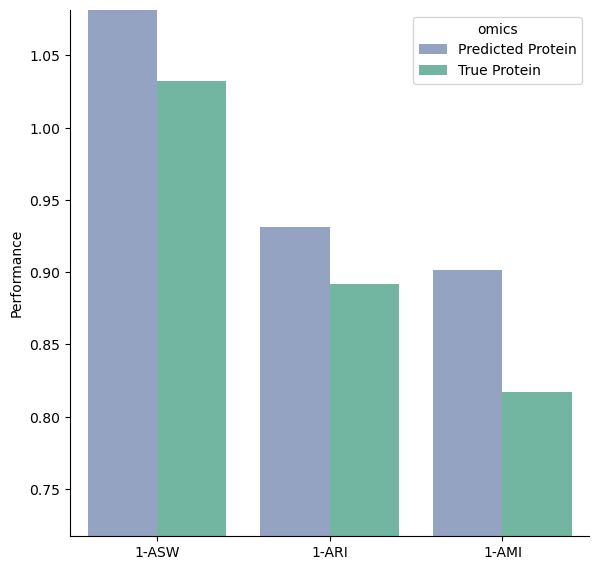

In [14]:
# True protein
adata = deepcopy(true_adata)
label_enc = preprocessing.LabelEncoder()
labels_true = label_enc.fit_transform(adata.obs[label_level].values)
batch = label_enc.fit_transform(adata.obs['donor'].values)
ASW, ARI, AMI = batch_clus(adata.X, labels_true, batch)
truth_result = ['True Protein', ARI, AMI, ASW]

# Predicted protein
adata = deepcopy(pro_adata)
kmeans = KMeans(n_clusters=8).fit(adata.obsm['X_pca'])
adata.obs['cluster'] = kmeans.labels_
ASW, ARI, AMI = batch_clus(adata.X, labels_true, batch)
pred_result = ['Predicted Protein', ARI, AMI, ASW]


log = pd.DataFrame([pred_result, truth_result], columns=['Omics', 'ARI', 'AMI', 'ASW'])
log_plot = pd.DataFrame(columns = ['omics', 'metric', 'performance'])
metic_list = ['ASW', 'ARI', 'AMI']
for i in range(len(log)):
    omics = log.iloc[i]['Omics']
    for (metric, j) in zip(metic_list, log.iloc[i][metic_list]):
        metric = '1-'+metric
        log_plot.loc[len(log_plot)] = [omics, metric, j]

# plotting
color = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[0],sns.color_palette("Set2")[1]]
g = sns.catplot(data=log_plot, x='metric', y='performance', kind="bar", hue="omics", errorbar="sd", palette=color, alpha=1, height=6, legend_out=False)
g.set_axis_labels('',"Performance")
plt.ylim(min(log_plot['performance'])-0.1,max(log_plot['performance']))
plt.show()

- Cell origin recognition on pan-cancer data

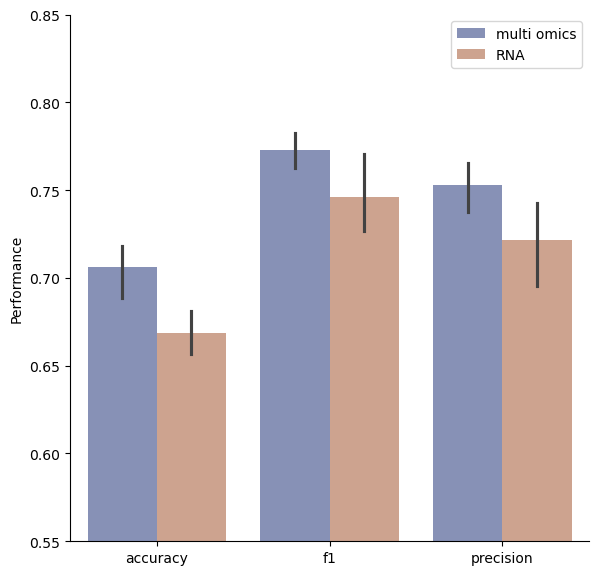

In [15]:
data = pd.read_csv(base_path + '/result/fig6/tumor_nontumor.csv')
g = sns.catplot(data=data, x='metric', y='performance', kind="bar", hue="omics", palette="dark", alpha=.5, height=6, legend_out=False)
g.set_axis_labels("","Performance")
g.legend.set_title("")
plt.ylim(0.55,0.85)
plt.show()